### Implementing a Balanced Oversampling Technique with a 10:1 Target Label Ratio

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

#### Start a simple Spark Session

In [2]:
spark = SparkSession.builder.appName('fraud_detection').master("local[*]").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/11 21:50:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
col_names = ['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip', 'Merchant Name', 'Merchant City', 
'Merchant State', 'MCC', 'Errors?', 'Is Fraud?', 'Hour', 'Minute', 'Date', 'Day_of_Week']

df = spark.read.option("delimiter", "|").csv('credit_card_transactions.csv', header=None, inferSchema=True).toDF(*col_names)
df = df.repartition(10)

24/06/11 21:50:29 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
stages = []
categorical_cols = ['Use Chip', 'Day_of_Week']
numerical_cols = ['Card', 'Year', 'Month', 'Day', 'Amount', 'MCC', 'Hour', 'Minute']

# Indexers for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+'_indexed') for col in categorical_cols]
# Encoders for categorical columns
encoders = [OneHotEncoder(inputCol=col+'_indexed', outputCol=col+'_OHE') for col in categorical_cols]

assembler = VectorAssembler(inputCols=(numerical_cols + ['Use Chip_OHE', 'Day_of_Week_OHE']),
                            outputCol='features')

lr_model = LogisticRegression(featuresCol='features', labelCol='Is Fraud?')

stages = indexers + encoders + [assembler, lr_model]

pipeline = Pipeline(stages=stages)

In [5]:
def oversample_minority(df):
    
    num_limit = 1000000
    fraction = num_limit / df.filter(col('Is Fraud?') == 0).count()

    df_normal = df.filter(col('Is Fraud?')==0).sample(withReplacement=False, fraction=fraction, seed=42)
    
    fraud_count = df.filter(col('Is Fraud?')==1).count()
    
    balance_ratio = num_limit / fraud_count
    
    oversampled_minority = df.filter(col('Is Fraud?')==1).sample(withReplacement=True, fraction=(balance_ratio/10), seed=42)
    oversampled_df = df_normal.union(oversampled_minority)
    
    return oversampled_df

In [6]:
oversample_balanced_df = oversample_minority(df)

In [7]:
oversample_balanced_df.groupBy('Is Fraud?').count().show()

+---------+------+
|Is Fraud?| count|
+---------+------+
|        0|999655|
|        1| 99820|
+---------+------+



In [8]:
train_oversampled, test_oversampled = oversample_balanced_df.randomSplit([0.8, 0.2], seed=42)

In [9]:
lr_oversampled_model = pipeline.fit(train_oversampled)

24/06/11 21:54:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/11 21:54:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [10]:
predictions = lr_oversampled_model.transform(test_oversampled)

In [11]:
my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Is Fraud?')
AUC = my_eval.evaluate(predictions)
AUC

0.5680184177175814

In [12]:
# Calculate confusion matrix manually
confusion_matrix = predictions.groupBy("Is Fraud?").pivot("prediction").count().na.fill(0).orderBy("Is Fraud?")
confusion_matrix.show()

+---------+------+----+
|Is Fraud?|   0.0| 1.0|
+---------+------+----+
|        0|198417|1364|
|        1| 17081|2847|
+---------+------+----+



In [13]:
# Convert confusion matrix to array for visualization
cm_array = confusion_matrix.collect()
print(f"cm_array1: {cm_array}")
cm_array = [row.asDict().values() for row in cm_array]
print(f"cm_array2: {cm_array}")
cm_array = [list(row)[1:] for row in cm_array]
print(f"cm_array3: {cm_array}")

cm_array1: [Row(Is Fraud?=0, 0.0=198417, 1.0=1364), Row(Is Fraud?=1, 0.0=17081, 1.0=2847)]
cm_array2: [dict_values([0, 198417, 1364]), dict_values([1, 17081, 2847])]
cm_array3: [[198417, 1364], [17081, 2847]]


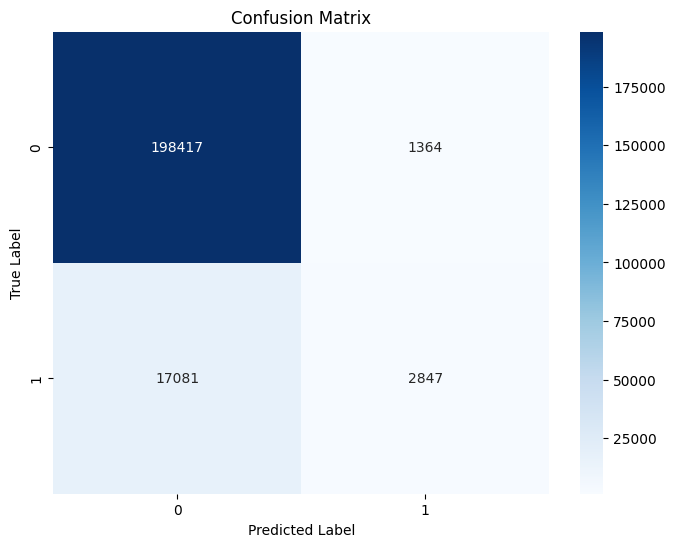

In [14]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_array, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [17]:
evaluator = MulticlassClassificationEvaluator(labelCol="Is Fraud?", predictionCol="prediction")

# Compute metrics
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})


evaluator_precision = MulticlassClassificationEvaluator(labelCol="Is Fraud?", predictionCol="prediction", metricName="precisionByLabel")
precision_label_0 = evaluator_precision.evaluate(predictions, {evaluator_precision.metricLabel: 0.0})
precision_label_1 = evaluator_precision.evaluate(predictions, {evaluator_precision.metricLabel: 1.0})

evaluator_recall = MulticlassClassificationEvaluator(labelCol="Is Fraud?", predictionCol="prediction", metricName="recallByLabel")
recall_label_0 = evaluator_recall.evaluate(predictions, {evaluator_recall.metricLabel: 0.0})
recall_label_1 = evaluator_recall.evaluate(predictions, {evaluator_recall.metricLabel: 1.0})


f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

print(f"Precision label 1: {precision_label_1}")
print(f"Recall label 1: {recall_label_1}")

print(f"Precision label 0: {precision_label_0}")
print(f"Recall label 0: {recall_label_0}")

24/06/11 23:29:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

**Accuracy**: 0.9160<br>
**F1 Score**: 0.8903<br>
**Precision label 1**: 0.6760<br>
**Recall label 1**: 0.1428<br>
**Precision label 0**: 0.9207<br>
**Recall label 0**: 0.9931<br>